In [18]:
%matplotlib inline

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

#With Data Transform

##With LR 0.001

###Load Data

In [21]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/Colab Notebooks/2021W_Postech_Study/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


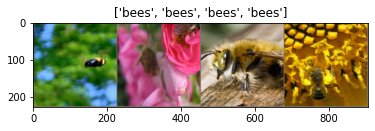

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

###Training the model

Training Func & Visualizing Func



In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

###Train All layers

In [25]:
model_ft = models.googlenet(pretrained=True)        #googlenet
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [26]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7300 Acc: 0.5615
val Loss: 0.6011 Acc: 0.6601

Epoch 1/24
----------
train Loss: 0.5952 Acc: 0.6844
val Loss: 0.7101 Acc: 0.6340

Epoch 2/24
----------
train Loss: 0.7021 Acc: 0.6066
val Loss: 0.7673 Acc: 0.6863

Epoch 3/24
----------
train Loss: 0.6487 Acc: 0.6434
val Loss: 0.7309 Acc: 0.6078

Epoch 4/24
----------
train Loss: 0.6306 Acc: 0.6803
val Loss: 0.7519 Acc: 0.7255

Epoch 5/24
----------
train Loss: 0.7039 Acc: 0.5902
val Loss: 0.6783 Acc: 0.5294

Epoch 6/24
----------
train Loss: 0.6043 Acc: 0.6926
val Loss: 0.5939 Acc: 0.7124

Epoch 7/24
----------
train Loss: 0.5597 Acc: 0.7459
val Loss: 0.4597 Acc: 0.7843

Epoch 8/24
----------
train Loss: 0.4809 Acc: 0.7910
val Loss: 0.5220 Acc: 0.7255

Epoch 9/24
----------
train Loss: 0.5367 Acc: 0.7336
val Loss: 0.4368 Acc: 0.7908

Epoch 10/24
----------
train Loss: 0.5034 Acc: 0.7418
val Loss: 0.4145 Acc: 0.8366

Epoch 11/24
----------
train Loss: 0.4994 Acc: 0.7541
val Loss: 0.4372 Acc: 0.8105

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


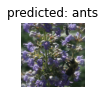

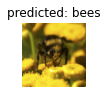

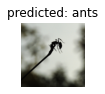

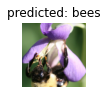

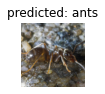

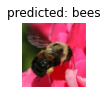

In [28]:
visualize_model(model_ft)

###Train Only FC layers

as feature extractor

In [29]:
model_conv = torchvision.models.googlenet(pretrained=True)
# Freeze all params
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 fc layer를 만들면서 requires_grad=True로 지정
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [30]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


Train and evaluate




In [31]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5816 Acc: 0.6885
val Loss: 0.4251 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.4962 Acc: 0.7664
val Loss: 0.3457 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4389 Acc: 0.8279
val Loss: 0.2756 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4009 Acc: 0.8197
val Loss: 0.2464 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4480 Acc: 0.7664
val Loss: 0.2489 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4513 Acc: 0.7992
val Loss: 0.2242 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3833 Acc: 0.7992
val Loss: 0.2304 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4084 Acc: 0.8320
val Loss: 0.2211 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3595 Acc: 0.8402
val Loss: 0.2292 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.4668 Acc: 0.7746
val Loss: 0.2184 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3893 Acc: 0.8238
val Loss: 0.2106 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.4384 Acc: 0.7910
val Loss: 0.2168 Acc: 0.9281

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


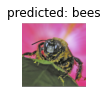

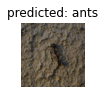

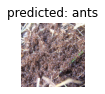

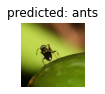

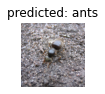

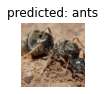

In [32]:
visualize_model(model_conv)

plt.ioff()
plt.show()

##With Lr 0.0001

###Train All layers

In [35]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

In [36]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


In [37]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4269 Acc: 0.7951
val Loss: 0.4330 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.4534 Acc: 0.7869
val Loss: 0.4449 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.4438 Acc: 0.7828
val Loss: 0.3656 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.3698 Acc: 0.8074
val Loss: 0.5230 Acc: 0.7843

Epoch 4/24
----------
train Loss: 0.4476 Acc: 0.7951
val Loss: 0.4111 Acc: 0.8170

Epoch 5/24
----------
train Loss: 0.4167 Acc: 0.8033
val Loss: 0.5200 Acc: 0.8105

Epoch 6/24
----------
train Loss: 0.3987 Acc: 0.8074
val Loss: 0.4463 Acc: 0.8235

Epoch 7/24
----------
train Loss: 0.4180 Acc: 0.8115
val Loss: 0.4867 Acc: 0.8105

Epoch 8/24
----------
train Loss: 0.4173 Acc: 0.8238
val Loss: 0.4836 Acc: 0.8105

Epoch 9/24
----------
train Loss: 0.3098 Acc: 0.8689
val Loss: 0.4079 Acc: 0.8431

Epoch 10/24
----------
train Loss: 0.3824 Acc: 0.8279
val Loss: 0.5405 Acc: 0.7843

Epoch 11/24
----------
train Loss: 0.4251 Acc: 0.7869
val Loss: 0.4369 Acc: 0.8301

Epoch 12/24
----------
t

###Train Only FC layer

In [38]:
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0001)

In [39]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


In [40]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4023 Acc: 0.8115
val Loss: 0.2490 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4105 Acc: 0.8197
val Loss: 0.2549 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.3799 Acc: 0.8484
val Loss: 0.2584 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4214 Acc: 0.8402
val Loss: 0.2566 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4017 Acc: 0.8361
val Loss: 0.2472 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3792 Acc: 0.8320
val Loss: 0.2534 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4075 Acc: 0.8443
val Loss: 0.2427 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3698 Acc: 0.8566
val Loss: 0.2543 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3965 Acc: 0.8320
val Loss: 0.2437 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.4201 Acc: 0.8156
val Loss: 0.2332 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.4002 Acc: 0.8279
val Loss: 0.2429 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3833 Acc: 0.8033
val Loss: 0.2280 Acc: 0.9281

Epoch 12/24
----------
t

#With Only 224 Resize

other conditions are same as first case

##With LR 0.001

###Load Data

In [41]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
#        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/Colab Notebooks/2021W_Postech_Study/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


###Train All layers

In [42]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

In [43]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


In [44]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6515 Acc: 0.6885
val Loss: 0.5077 Acc: 0.7974

Epoch 1/24
----------
train Loss: 0.6265 Acc: 0.6721
val Loss: 1.3372 Acc: 0.7124

Epoch 2/24
----------
train Loss: 0.6878 Acc: 0.6066
val Loss: 2.3737 Acc: 0.4967

Epoch 3/24
----------
train Loss: 0.6323 Acc: 0.6475
val Loss: 0.7384 Acc: 0.5817

Epoch 4/24
----------
train Loss: 0.6321 Acc: 0.6680
val Loss: 0.6229 Acc: 0.6863

Epoch 5/24
----------
train Loss: 0.6188 Acc: 0.7172
val Loss: 0.8118 Acc: 0.5098

Epoch 6/24
----------
train Loss: 0.5809 Acc: 0.7049
val Loss: 0.8133 Acc: 0.5033

Epoch 7/24
----------
train Loss: 0.6847 Acc: 0.5820
val Loss: 0.5857 Acc: 0.7516

Epoch 8/24
----------
train Loss: 0.6218 Acc: 0.6803
val Loss: 0.4898 Acc: 0.7908

Epoch 9/24
----------
train Loss: 0.5611 Acc: 0.7213
val Loss: 0.8419 Acc: 0.6405

Epoch 10/24
----------
train Loss: 0.6218 Acc: 0.6803
val Loss: 0.5535 Acc: 0.7908

Epoch 11/24
----------
train Loss: 0.5816 Acc: 0.7090
val Loss: 2.5699 Acc: 0.5359

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


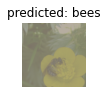

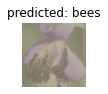

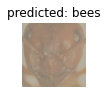

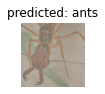

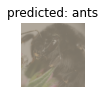

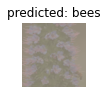

In [45]:
visualize_model(model_ft)

plt.ioff()
plt.show()

###Train Only FC layers

In [46]:
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

In [47]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


In [48]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4402 Acc: 0.7664
val Loss: 0.2452 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.5244 Acc: 0.7500
val Loss: 0.2361 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4557 Acc: 0.7787
val Loss: 0.2181 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3755 Acc: 0.8361
val Loss: 0.2090 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3877 Acc: 0.8525
val Loss: 0.2414 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.3745 Acc: 0.8484
val Loss: 0.2074 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4819 Acc: 0.7787
val Loss: 0.1974 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3616 Acc: 0.8402
val Loss: 0.2059 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3311 Acc: 0.8770
val Loss: 0.1968 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4647 Acc: 0.7623
val Loss: 0.1835 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.4107 Acc: 0.8197
val Loss: 0.2168 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.4180 Acc: 0.7910
val Loss: 0.2583 Acc: 0.9216

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


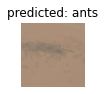

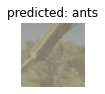

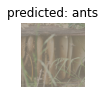

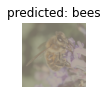

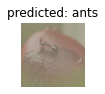

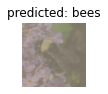

In [49]:
visualize_model(model_conv)

plt.ioff()
plt.show()

##With LR 0.0001

###Train All Layers

In [54]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

In [55]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


In [56]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4889 Acc: 0.7664
val Loss: 0.4558 Acc: 0.7974

Epoch 1/24
----------
train Loss: 0.4722 Acc: 0.7787
val Loss: 0.4643 Acc: 0.7843

Epoch 2/24
----------
train Loss: 0.4575 Acc: 0.8033
val Loss: 0.5397 Acc: 0.7451

Epoch 3/24
----------
train Loss: 0.5040 Acc: 0.7746
val Loss: 0.4985 Acc: 0.7647

Epoch 4/24
----------
train Loss: 0.4397 Acc: 0.8115
val Loss: 0.4542 Acc: 0.7778

Epoch 5/24
----------
train Loss: 0.4853 Acc: 0.7623
val Loss: 0.4434 Acc: 0.8039

Epoch 6/24
----------
train Loss: 0.4764 Acc: 0.7828
val Loss: 0.4880 Acc: 0.7582

Epoch 7/24
----------
train Loss: 0.4485 Acc: 0.8074
val Loss: 0.4716 Acc: 0.7647

Epoch 8/24
----------
train Loss: 0.4171 Acc: 0.8279
val Loss: 0.5486 Acc: 0.7255

Epoch 9/24
----------
train Loss: 0.4448 Acc: 0.8238
val Loss: 0.4839 Acc: 0.7778

Epoch 10/24
----------
train Loss: 0.3744 Acc: 0.8361
val Loss: 0.4572 Acc: 0.7778

Epoch 11/24
----------
train Loss: 0.4236 Acc: 0.8115
val Loss: 0.4692 Acc: 0.7778

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


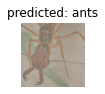

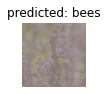

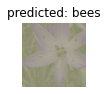

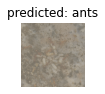

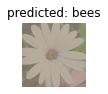

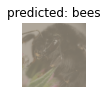

In [57]:
visualize_model(model_ft)

plt.ioff()
plt.show()

###Train Only FC layers

In [58]:
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0001)

In [59]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


In [60]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4103 Acc: 0.8320
val Loss: 0.2294 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4640 Acc: 0.7746
val Loss: 0.2323 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.3649 Acc: 0.8525
val Loss: 0.2388 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4023 Acc: 0.8156
val Loss: 0.2142 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3749 Acc: 0.8443
val Loss: 0.2257 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3743 Acc: 0.8197
val Loss: 0.2310 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4025 Acc: 0.7992
val Loss: 0.2230 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4720 Acc: 0.7623
val Loss: 0.2301 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3675 Acc: 0.8484
val Loss: 0.2232 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3747 Acc: 0.8320
val Loss: 0.2285 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3882 Acc: 0.8238
val Loss: 0.2234 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3551 Acc: 0.8607
val Loss: 0.2303 Acc: 0.9412

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


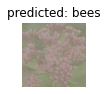

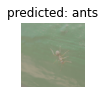

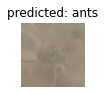

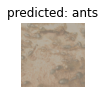

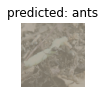

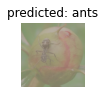

In [61]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



